In [17]:
# !pip install numpy pandas scikit-learn torch torchvision torchaudio matplotlib tqdm --quiet

import os, re, glob, math, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Paths / config
BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"
TRAIN_CUTTERS = ["c1", "c4", "c6"]   # labeled
TEST_CUTTERS  = ["c2", "c3", "c5"]   # unlabeled
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [18]:
def read_wear_table(cutter_dir):
    import pandas as pd, numpy as np, glob, os, re

    # find wear csv
    cands = [p for p in glob.glob(os.path.join(cutter_dir, "*.csv")) if "wear" in os.path.basename(p).lower()]
    if not cands:
        raise FileNotFoundError(f"No wear csv in {cutter_dir}")
    wear_file = cands[0]

    # try header/no-header
    raw0 = pd.read_csv(wear_file, sep=None, engine="python", nrows=5)
    use_header = True
    try:
        v = pd.to_numeric(raw0.iloc[0,0], errors="coerce")
        use_header = bool(pd.isna(v))  # if first is non-numeric, assume header
    except Exception:
        use_header = True

    raw = pd.read_csv(wear_file, sep=None, engine="python") if use_header else \
          pd.read_csv(wear_file, sep=None, engine="python", header=None)

    raw.columns = [str(c).strip().lower() for c in raw.columns]

    def first_present(names):
        for n in names:
            if n in raw.columns: return n
        return None

    cut_col = first_present(["cut","cut_number","cut no","cut_no","c","index","id","0"])
    f1_col  = first_present(["flute_1","flute1","f1","flute 1","1"])
    f2_col  = first_present(["flute_2","flute2","f2","flute 2","2"])
    f3_col  = first_present(["flute_3","flute3","f3","flute 3","3"])

    if cut_col is None or f1_col is None or f2_col is None or f3_col is None:
        tmp = raw.copy().dropna(axis=1, how="all")
        if tmp.shape[1] < 4:
            raise ValueError("Wear file does not have at least 4 usable columns (cut + 3 flutes).")
        tmp.columns = [f"col_{i}" for i in range(tmp.shape[1])]
        cut_col, f1_col, f2_col, f3_col = "col_0","col_1","col_2","col_3"
        raw = tmp

    # clean/convert
    cut_series = raw[cut_col].astype(str).str.extract(r"(\d+)", expand=False)
    cut_series = pd.to_numeric(cut_series, errors="coerce")

    f1 = pd.to_numeric(raw[f1_col], errors="coerce")
    f2 = pd.to_numeric(raw[f2_col], errors="coerce")
    f3 = pd.to_numeric(raw[f3_col], errors="coerce")

    df = pd.DataFrame({
        "Cut_Number": cut_series,
        "flute_1": f1,
        "flute_2": f2,
        "flute_3": f3,
    }).dropna()

    df["Cut_Number"] = df["Cut_Number"].round().astype(int)
    df["wear_max"] = df[["flute_1","flute_2","flute_3"]].max(axis=1)
    EOL = float(df["wear_max"].max())
    df["RUL"] = EOL - df["wear_max"]

    return df.sort_values("Cut_Number").reset_index(drop=True), EOL


def discover_cut_files(cutter_dir, cutter_id):
    # recursive, robust to nested c1\c1\...
    all_csvs = glob.glob(os.path.join(cutter_dir, "**", "*.csv"), recursive=True)
    all_csvs = [p for p in all_csvs if "wear" not in os.path.basename(p).lower()]
    cuts = {}
    for p in all_csvs:
        name = os.path.basename(p).lower()
        m = re.search(rf"c[_-]?{cutter_id}[_-]?(\d+)\.csv$", name) or re.search(r"(\d+)\.csv$", name)
        if m:
            cuts[int(m.group(1))] = p
    return dict(sorted(cuts.items()))


In [19]:
c1_tbl, c1_eol = read_wear_table(os.path.join(BASE, "c1"))
print("c1:", len(c1_tbl), "EOL:", round(c1_eol,2), "first rows:\n", c1_tbl.head())


c1: 315 EOL: 172.69 first rows:
    Cut_Number    flute_1    flute_2    flute_3   wear_max         RUL
0           1  32.317114  48.892617  37.720825  48.892617  123.794220
1           2  37.914879  49.570815  37.720825  49.570815  123.116022
2           3  43.087910  50.302867  37.720825  50.302867  122.383970
3           4  47.859072  51.083652  37.849851  51.083652  121.603185
4           5  52.250329  51.908288  38.172665  52.250329  120.436508


In [20]:
# Windowing / features
WIN = 4096          # ~82 ms at 50 kHz
HOP = 4096          # no overlap (fast)
MAX_WINDOWS = 64    # each cut -> [T<=64, 49]

def window_feats_1d(x):
    mean = x.mean()
    std  = x.std()
    rms  = np.sqrt(np.mean(x**2)) if x.size else 0.0
    mx   = x.max() if x.size else 0.0
    crest = (mx / (rms + 1e-9))

    X = np.fft.rfft(x, n=len(x)) if x.size else np.array([0.0])
    P = (np.abs(X)**2)
    power = P.sum()
    if power < 1e-12 or not x.size:
        centroid = 0.0
    else:
        freqs = np.fft.rfftfreq(len(x), d=1.0/50000.0)
        centroid = float((freqs * P).sum() / power)

    return np.array([mean, std, rms, mx, power, centroid, crest], dtype=np.float32)

def extract_cut_windows(path):
    try:
        df = pd.read_csv(path, header=None, engine="c", low_memory=False)
    except Exception:
        df = pd.read_csv(path, header=None, engine="python", low_memory=False)
    df = df.dropna(axis=1, how="all")
    if df.shape[1] < 7:
        return None  # malformed

    arr = df.iloc[:, :7].to_numpy(dtype=np.float32, copy=False)
    N = arr.shape[0]
    feats = []
    if N >= WIN:
        for start in range(0, N - WIN + 1, HOP):
            seg = arr[start:start+WIN, :]  # [WIN,7]
            fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
            feats.append(np.concatenate(fwin, axis=0))  # 7*7 = 49
            if len(feats) >= MAX_WINDOWS: break
    else:
        # too short for one full window → compute one "global" window on entire cut
        seg = arr
        fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
        feats.append(np.concatenate(fwin, axis=0))

    F = np.stack(feats, axis=0)  # [T,49], T>=1 now guaranteed
    T = F.shape[0]
    if T < MAX_WINDOWS:
        pad = np.zeros((MAX_WINDOWS - T, F.shape[1]), dtype=np.float32)
        F = np.concatenate([F, pad], axis=0)
    else:
        F = F[:MAX_WINDOWS]
        T = MAX_WINDOWS
    return F, T


In [21]:
def build_index_for_cutters(cutters, labeled=True):
    index = []
    for cname in cutters:
        cutter_dir = os.path.join(BASE, cname)
        cutter_id = int(re.findall(r"\d+", cname)[0])

        cut_files = discover_cut_files(cutter_dir, cutter_id)

        if labeled:
            wear_df, _ = read_wear_table(cutter_dir)
            present = sorted(set(wear_df["Cut_Number"].astype(int)).intersection(cut_files.keys()))
            for cutn in present:
                labels = wear_df.loc[wear_df["Cut_Number"]==cutn, ["flute_1","flute_2","flute_3","wear_max","RUL"]] \
                                 .iloc[0].to_numpy(dtype=np.float32)
                prev_cut = cutn-1 if (cutn-1) in present else None
                index.append({
                    "cutter": cname,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": (cut_files[prev_cut] if prev_cut is not None else None),
                    "y": labels
                })
        else:
            present = sorted(cut_files.keys())
            for cutn in present:
                prev_cut = cutn-1 if (cutn-1) in present else None
                index.append({
                    "cutter": cname,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": (cut_files[prev_cut] if prev_cut is not None else None),
                    "y": None
                })
    return index

train_index = build_index_for_cutters(TRAIN_CUTTERS, labeled=True)
test_index  = build_index_for_cutters(TEST_CUTTERS, labeled=False)

print("Train samples:", len(train_index))
print("Test samples:", len(test_index))
print("Example train item:", train_index[0])
print("Example test  item:", test_index[0])


Train samples: 945
Test samples: 945
Example train item: {'cutter': 'c1', 'cut_number': 1, 'path': 'E:\\Collaboration Work\\With Farooq\\phm dataset\\PHM Challange 2010 Milling\\c1\\c1\\c_1_001.csv', 'prev_path': None, 'y': array([ 32.317112,  48.892616,  37.720825,  48.892616, 123.79422 ],
      dtype=float32)}
Example test  item: {'cutter': 'c2', 'cut_number': 1, 'path': 'E:\\Collaboration Work\\With Farooq\\phm dataset\\PHM Challange 2010 Milling\\c2\\c2\\c_2_001.csv', 'prev_path': None, 'y': None}


In [22]:
class PHMWindowDataset(Dataset):
    def __init__(self, index, scaler=None, fit_scaler=False):
        self.index = index
        self.scaler = scaler
        self.fit_scaler = fit_scaler

        if self.fit_scaler:
            stacks = []
            for item in tqdm(self.index, desc="Fitting scaler (train windows)"):
                out = extract_cut_windows(item["path"])
                if out is None: continue
                X, L = out
                stacks.append(X[:int(L)])  # only valid windows
            if not stacks:
                raise RuntimeError("No windows found to fit scaler.")
            S = np.concatenate(stacks, axis=0)  # [sum_T, 49]
            self.scaler = StandardScaler().fit(S)

    def __len__(self): return len(self.index)

    def __getitem__(self, i):
        item = self.index[i]
        Xout = extract_cut_windows(item["path"])
        if Xout is None:
            X = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); L = 1
        else:
            X, L = Xout
            L = max(int(L), 1)

        if self.scaler is not None:
            X = self.scaler.transform(X)

        # previous cut for monotonic penalty
        if item["prev_path"] is not None:
            Xpout = extract_cut_windows(item["prev_path"])
            if Xpout is None:
                Xp = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); Lp = 1
            else:
                Xp, Lp = Xpout
                Lp = max(int(Lp), 1)
            if self.scaler is not None:
                Xp = self.scaler.transform(Xp)
        else:
            Xp = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); Lp = 0  # no prev

        y = item["y"]
        if y is None:
            y = np.full((5,), np.nan, dtype=np.float32)

        return (torch.tensor(X, dtype=torch.float32),
                torch.tensor(L, dtype=torch.long),     # pack_padded_sequence expects long
                torch.tensor(Xp, dtype=torch.float32),
                torch.tensor(Lp, dtype=torch.long),
                torch.tensor(y, dtype=torch.float32),
                item["cut_number"],
                item["cutter"])

# Build datasets/loaders
full_train_ds = PHMWindowDataset(train_index, scaler=None, fit_scaler=True)
scaler = full_train_ds.scaler

# split train/val
val_ratio = 0.15
val_n = int(len(full_train_ds)*val_ratio)
train_n = len(full_train_ds) - val_n
train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [train_n, val_n], generator=torch.Generator().manual_seed(SEED))

test_ds  = PHMWindowDataset(test_index, scaler=scaler, fit_scaler=False)

def collate(batch):
    X, L, Xp, Lp, y, cutn, cutter = zip(*batch)
    return (torch.stack(X), torch.stack(L),
            torch.stack(Xp), torch.stack(Lp),
            torch.stack(y),
            np.array(cutn, dtype=int), np.array(cutter))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0, collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=0, collate_fn=collate)

print("Batches -> train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))


Fitting scaler (train windows): 100%|██████████| 945/945 [02:34<00:00,  6.12it/s]

Batches -> train: 101 val: 18 test: 119


In [23]:
class MultiTaskRULNet(nn.Module):
    def __init__(self, input_dim=49, hidden=128, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)   # also on during MC-dropout inference
        self.head_f1 = nn.Linear(hidden, 1)
        self.head_f2 = nn.Linear(hidden, 1)
        self.head_f3 = nn.Linear(hidden, 1)
        self.head_max= nn.Linear(hidden, 1)
        self.head_rul= nn.Linear(hidden, 1)

    def forward(self, X, L):
        # clamp lengths to >=1 for safety
        Lc = torch.clamp(L, min=1)
        packed = nn.utils.rnn.pack_padded_sequence(X, lengths=Lc.cpu(), batch_first=True, enforce_sorted=False)
        out, (h, c) = self.lstm(packed)
        hlast = h[-1]  # [B,H]
        z = self.dropout(hlast)
        f1 = self.head_f1(z).squeeze(1)
        f2 = self.head_f2(z).squeeze(1)
        f3 = self.head_f3(z).squeeze(1)
        wmax = self.head_max(z).squeeze(1)
        rul  = self.head_rul(z).squeeze(1)
        return f1, f2, f3, wmax, rul

def multitask_loss(preds, y, mono=None, lambda_mono=0.2, weights=(0.5,0.5,0.5,1.0,1.5)):
    # y may contain NaNs for unlabeled; mask them out
    f1,f2,f3,wmax,rul = preds
    mse = nn.MSELoss(reduction='none')

    loss = 0.0
    # flute 1..3, wear_max, RUL
    for pred, tgt, w in zip([f1,f2,f3,wmax,rul], [y[:,0],y[:,1],y[:,2],y[:,3],y[:,4]], weights):
        mask = torch.isfinite(tgt).float()
        if mask.sum() > 0:
            l = mse(pred, tgt)
            loss += w * (l * mask).sum() / (mask.sum() + 1e-9)

    if mono is not None:
        f1p,f2p,f3p,wmaxp,mask_prev = mono
        relu = nn.ReLU()
        m = mask_prev.float()
        if m.sum() > 0:
            penalty = (
                (relu(f1p - f1) + relu(f2p - f2) + relu(f3p - f3) + 2*relu(wmaxp - wmax)) * m
            ).sum() / (m.sum() + 1e-9)
            loss = loss + lambda_mono * penalty
    return loss


In [24]:
model = MultiTaskRULNet(input_dim=49, hidden=128, dropout=0.3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    tot = 0.0; n=0
    all_true=[]; all_pred=[]

    for X,L,Xp,Lp,y,cutn,cutter in loader:
        X  = X.to(device);  L  = L.to(device)
        Xp = Xp.to(device); Lp = Lp.to(device)
        y  = y.to(device)

        if train: opt.zero_grad()

        preds = model(X,L)

        # Monotonic penalty only where we have a previous cut (Lp>0) AND we have labels (finite y)
        with torch.no_grad():
            # Build mask: previous exists & label exists for wear_max target
            mask_prev = (Lp > 0) & torch.isfinite(y[:,3])
        mono = None
        if mask_prev.any():
            # select only those that have prev & labels
            idx = mask_prev.nonzero(as_tuple=True)[0]
            Xp_sel, Lp_sel = Xp[idx], torch.clamp(Lp[idx], min=1)
            # eval for prev preds (eval mode to stabilize), then restore mode
            was_training = model.training
            model.eval()
            f1p,f2p,f3p,wmaxp,_ = model(Xp_sel, Lp_sel)
            if was_training: model.train()
            # create a full-batch vector with zeros and scatter selected preds
            f1p_full = torch.zeros_like(preds[0]); f1p_full[idx] = f1p
            f2p_full = torch.zeros_like(preds[1]); f2p_full[idx] = f2p
            f3p_full = torch.zeros_like(preds[2]); f3p_full[idx] = f3p
            wmp_full = torch.zeros_like(preds[3]); wmp_full[idx] = wmaxp
            mono = (f1p_full, f2p_full, f3p_full, wmp_full, mask_prev.to(device).float())

        loss = multitask_loss(preds, y, mono=mono, lambda_mono=0.2)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        tot += float(loss.item()) * X.size(0)
        n   += X.size(0)

        with torch.no_grad():
            _,_,_,wmax_pred,rul_pred = preds
            all_true.append(y[:,3:5].detach().cpu().numpy())    # wear_max, RUL (may contain NaN)
            all_pred.append(torch.stack([wmax_pred, rul_pred], dim=1).detach().cpu().numpy())

    Y = np.vstack(all_true)          # shape [N,2] (may have NaNs)
    P = np.vstack(all_pred)          # shape [N,2]

    # compute metrics only on rows where labels exist
    mask_w = np.isfinite(Y[:,0])
    mask_r = np.isfinite(Y[:,1])

    wear_rmse = math.sqrt(mean_squared_error(Y[mask_w,0], P[mask_w,0])) if mask_w.any() else float('nan')
    wear_r2   = r2_score(Y[mask_w,0], P[mask_w,0])                       if mask_w.any() else float('nan')
    rul_rmse  = math.sqrt(mean_squared_error(Y[mask_r,1], P[mask_r,1]))  if mask_r.any() else float('nan')
    rul_r2    = r2_score(Y[mask_r,1], P[mask_r,1])                       if mask_r.any() else float('nan')

    return tot/n, wear_rmse, wear_r2, rul_rmse, rul_r2

best = 1e18; EPOCHS = 15
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader,   train=False)
    print(f"Epoch {ep:02d} | train loss {tr[0]:.3f} | wear RMSE {tr[1]:.2f} R² {tr[2]:.3f} | "
          f"val wear RMSE {va[1]:.2f} R² {va[2]:.3f} | val RUL RMSE {va[3]:.2f} R² {va[4]:.3f}")
    val_score = (0 if np.isnan(va[1]) else va[1]) + (0 if np.isnan(va[3]) else va[3])
    if val_score < best:
        best = val_score
        torch.save(model.state_dict(), "best_mtl_rul.pt")


Epoch 01 | train loss 46513.733 | wear RMSE 121.24 R² -7.692 | val wear RMSE 107.14 R² -6.182 | val RUL RMSE 86.25 R² -3.514
Epoch 02 | train loss 36483.820 | wear RMSE 108.32 R² -5.939 | val wear RMSE 95.06 R² -4.654 | val RUL RMSE 75.35 R² -2.445
Epoch 03 | train loss 28434.640 | wear RMSE 96.24 R² -4.478 | val wear RMSE 83.35 R² -3.347 | val RUL RMSE 65.79 R² -1.627
Epoch 04 | train loss 21898.556 | wear RMSE 84.77 R² -3.249 | val wear RMSE 72.14 R² -2.256 | val RUL RMSE 57.47 R² -1.004
Epoch 05 | train loss 16494.642 | wear RMSE 73.49 R² -2.194 | val wear RMSE 61.73 R² -1.384 | val RUL RMSE 50.60 R² -0.554
Epoch 06 | train loss 12584.980 | wear RMSE 63.32 R² -1.371 | val wear RMSE 52.61 R² -0.732 | val RUL RMSE 45.82 R² -0.274
Epoch 07 | train loss 9767.533 | wear RMSE 54.40 R² -0.750 | val wear RMSE 45.52 R² -0.296 | val RUL RMSE 42.88 R² -0.116
Epoch 08 | train loss 8157.141 | wear RMSE 48.07 R² -0.367 | val wear RMSE 41.63 R² -0.084 | val RUL RMSE 41.43 R² -0.042
Epoch 09 | trai

VAL metrics: {'wear_rmse': 29.448218465652236, 'wear_r2': 0.4574141502380371, 'rul_rmse': 43.11630347096096, 'rul_r2': -0.12818801403045654}


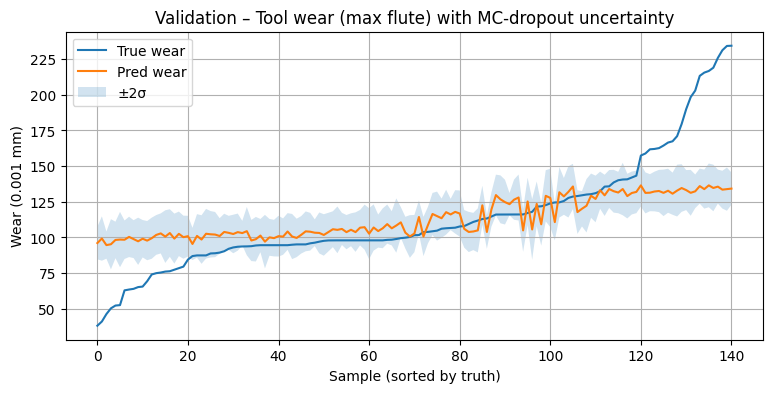

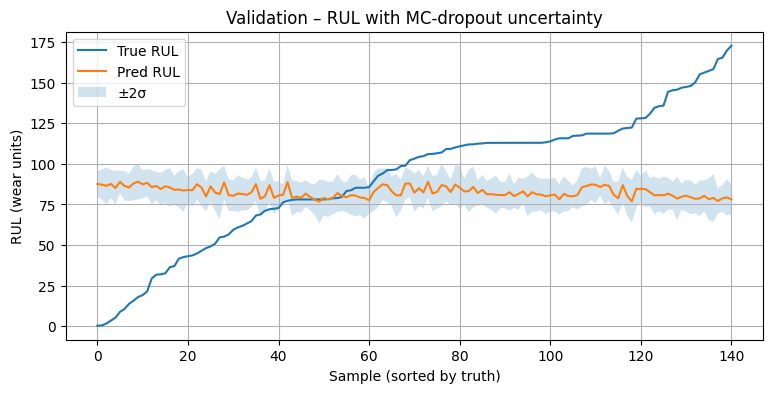

In [25]:
model.load_state_dict(torch.load("best_mtl_rul.pt", map_location=device))

def mc_predict_loader(loader, n_samples=20, compute_metrics=True):
    model.train()  # enable dropout for MC
    true_list=[]; wear_mu=[]; wear_sd=[]; rul_mu=[]; rul_sd=[]
    ids=[]

    for X,L,_,_,y,cutn,cutter in loader:
        X = X.to(device); L = torch.clamp(L.to(device), min=1)
        true_list.append(y[:,3:5].numpy())  # may contain NaNs
        ids.append(np.stack([cutn, cutter], axis=1))

        with torch.no_grad():
            ws, rs = [], []
            for _ in range(n_samples):
                _,_,_,wmax,rul = model(X,L)
                ws.append(wmax.cpu().numpy())
                rs.append(rul.cpu().numpy())
            W = np.stack(ws, axis=0)  # [S,B]
            R = np.stack(rs, axis=0)
            wear_mu.append(W.mean(0)); wear_sd.append(W.std(0))
            rul_mu.append(R.mean(0));  rul_sd.append(R.std(0))

    Y  = np.vstack(true_list)
    MUw= np.concatenate(wear_mu, axis=0)
    SDw= np.concatenate(wear_sd, axis=0)
    MUr= np.concatenate(rul_mu, axis=0)
    SDr= np.concatenate(rul_sd, axis=0)
    IDS= np.concatenate(ids, axis=0)  # columns: cut_number, cutter (strings)

    metrics = {}
    if compute_metrics:
        mw = np.isfinite(Y[:,0]); mr = np.isfinite(Y[:,1])
        if mw.any():
            metrics["wear_rmse"] = float(np.sqrt(mean_squared_error(Y[mw,0], MUw[mw])))
            metrics["wear_r2"]   = float(r2_score(Y[mw,0], MUw[mw]))
        if mr.any():
            metrics["rul_rmse"]  = float(np.sqrt(mean_squared_error(Y[mr,1], MUr[mr])))
            metrics["rul_r2"]    = float(r2_score(Y[mr,1], MUr[mr]))
    return Y, MUw, SDw, MUr, SDr, IDS, metrics

# Validation (has labels)
Yv, Wm_v, Ws_v, Rm_v, Rs_v, IDv, metrics_v = mc_predict_loader(val_loader, n_samples=20, compute_metrics=True)
print("VAL metrics:", metrics_v)

# Pretty plots (VAL)
order = np.argsort(Yv[:,0][np.isfinite(Yv[:,0])])
x = np.arange(order.size)
plt.figure(figsize=(9,4))
plt.plot(x, Yv[:,0][np.isfinite(Yv[:,0])][order], label="True wear")
plt.plot(x, Wm_v[np.isfinite(Yv[:,0])][order], label="Pred wear")
pm = Wm_v[np.isfinite(Yv[:,0])][order]; ps = Ws_v[np.isfinite(Yv[:,0])][order]
plt.fill_between(x, pm-2*ps, pm+2*ps, alpha=0.2, label="±2σ")
plt.title("Validation – Tool wear (max flute) with MC-dropout uncertainty")
plt.xlabel("Sample (sorted by truth)"); plt.ylabel("Wear (0.001 mm)"); plt.grid(True); plt.legend(); plt.show()

order = np.argsort(Yv[:,1][np.isfinite(Yv[:,1])])
x = np.arange(order.size)
plt.figure(figsize=(9,4))
plt.plot(x, Yv[:,1][np.isfinite(Yv[:,1])][order], label="True RUL")
plt.plot(x, Rm_v[np.isfinite(Yv[:,1])][order], label="Pred RUL")
pm = Rm_v[np.isfinite(Yv[:,1])][order]; ps = Rs_v[np.isfinite(Yv[:,1])][order]
plt.fill_between(x, pm-2*ps, pm+2*ps, alpha=0.2, label="±2σ")
plt.title("Validation – RUL with MC-dropout uncertainty")
plt.xlabel("Sample (sorted by truth)"); plt.ylabel("RUL (wear units)"); plt.grid(True); plt.legend(); plt.show()


Saved: test_predictions_with_uncertainty.csv


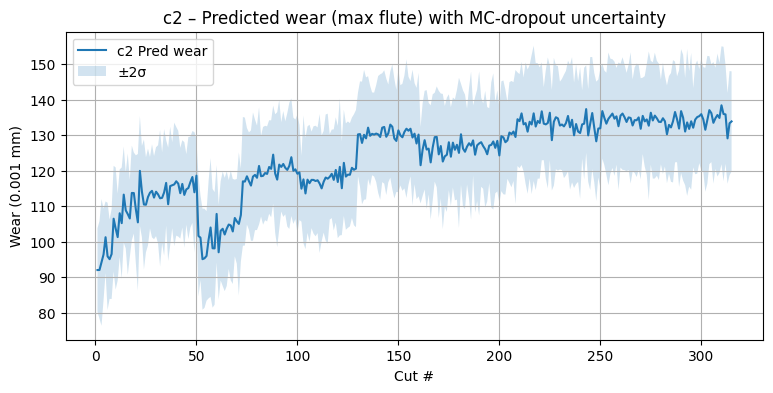

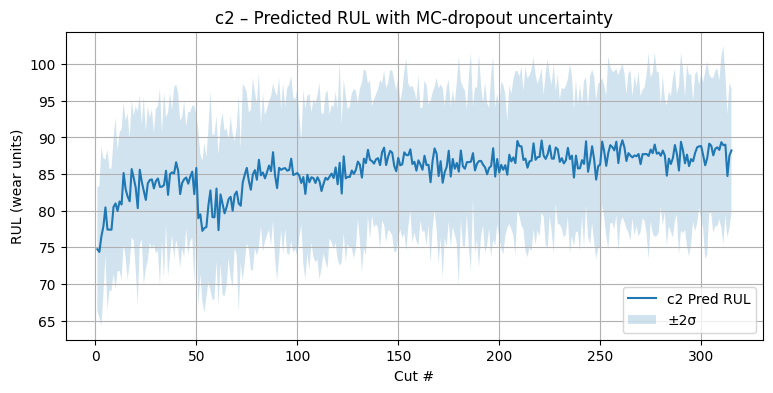

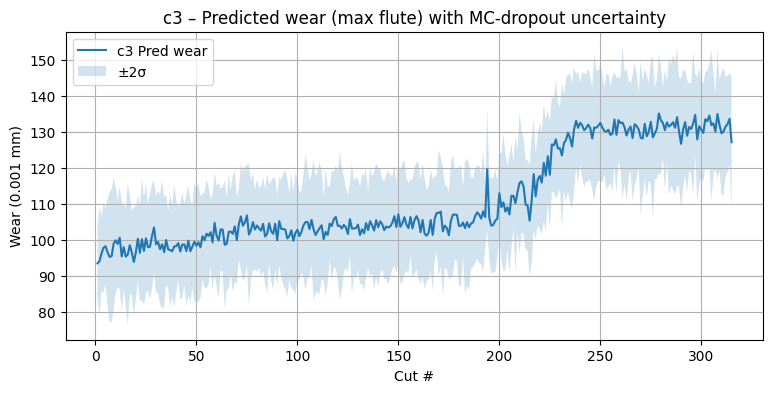

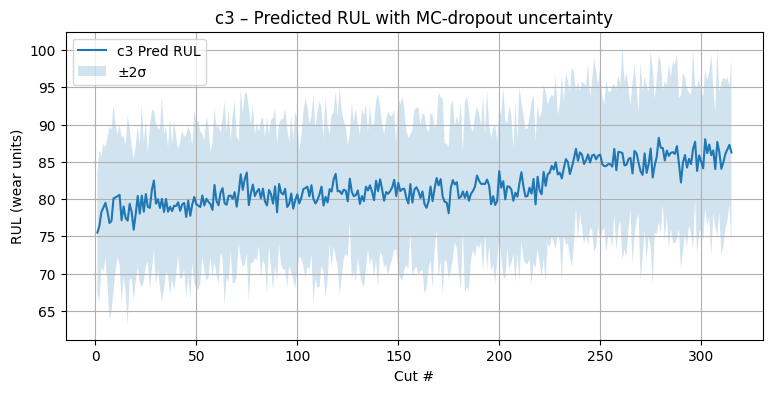

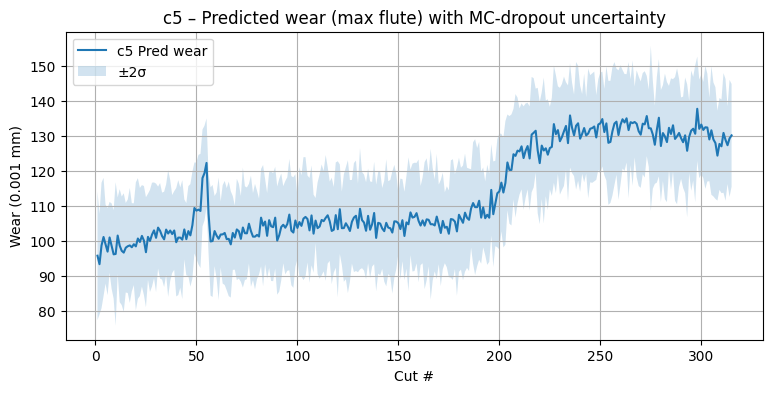

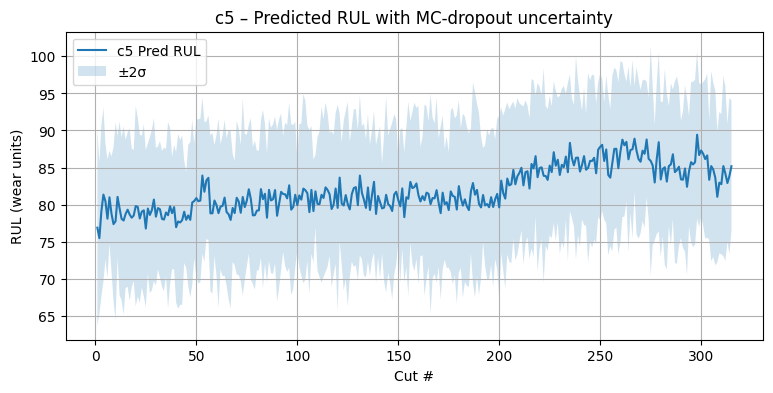

In [26]:
# TEST (unlabeled) – produce predictions and uncertainty, save for your paper
Yt, Wm_t, Ws_t, Rm_t, Rs_t, IDt, _ = mc_predict_loader(test_loader, n_samples=20, compute_metrics=False)

out = pd.DataFrame({
    "cutter": IDt[:,1],
    "cut_number": IDt[:,0].astype(int),
    "pred_wear_max": Wm_t,
    "pred_wear_max_std": Ws_t,
    "pred_rul": Rm_t,
    "pred_rul_std": Rs_t,
})
out = out.sort_values(["cutter","cut_number"]).reset_index(drop=True)
save_path = "test_predictions_with_uncertainty.csv"
out.to_csv(save_path, index=False)
print("Saved:", save_path)

# Visual idea: plot per-cutter predicted wear curves with ±2σ bands
for cname in TEST_CUTTERS:
    dd = out[out["cutter"]==cname]
    if dd.empty: continue
    x = dd["cut_number"].values
    mu = dd["pred_wear_max"].values
    sd = dd["pred_wear_max_std"].values
    plt.figure(figsize=(9,4))
    plt.plot(x, mu, label=f"{cname} Pred wear")
    plt.fill_between(x, mu-2*sd, mu+2*sd, alpha=0.2, label="±2σ")
    plt.title(f"{cname} – Predicted wear (max flute) with MC-dropout uncertainty")
    plt.xlabel("Cut #"); plt.ylabel("Wear (0.001 mm)"); plt.grid(True); plt.legend(); plt.show()

    mu = dd["pred_rul"].values
    sd = dd["pred_rul_std"].values
    plt.figure(figsize=(9,4))
    plt.plot(x, mu, label=f"{cname} Pred RUL")
    plt.fill_between(x, mu-2*sd, mu+2*sd, alpha=0.2, label="±2σ")
    plt.title(f"{cname} – Predicted RUL with MC-dropout uncertainty")
    plt.xlabel("Cut #"); plt.ylabel("RUL (wear units)"); plt.grid(True); plt.legend(); plt.show()
